# Predicting No Show Appointments in Brazil (Kaggle Challenge)

#### How likely is a patient with certain attributes, to show up to his hospital appointment? 

In this project we investigate a data set of appoinment records in public hospitals in Vitoria, Espirito Santo, Brazil. The data includes whether the patient showed up to the appointment, which is the main focus, as well as other attributes of the patient and the appointment.

The data set is provided by JoniHoppen on [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments).

#### Analysis Questions:

- Exploration: which factors have a strong correlation with no-shows?
- How do the neighborhoods compare with regard to no-shows?
- How do the genders compare?
- How is age related to no-shows?
- Does the waiting time betweeen scheduling and appointment play a role?
- Does the day of the week (of the appointment) play a role?
- Can SMS reminder help to prevent no-shows?

This Notebook will present summary statistics and plots to answer the questions above.

---

#### Imports and Opening Dataset

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [52]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv', parse_dates=True)
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


#### Dataset Overview

In [53]:
df.shape

(110527, 14)

we have more than 100,000 cases and 14 attributes 

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


no missing values, but problem with datetime

---

## Data Wrangling 

#### New Columns for Date and Time

In [55]:
df[['Scheduled_Day', 'Scheduled_Hour']] = df['ScheduledDay'].str.split('T', expand=True)
df.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled_Day,Scheduled_Hour
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29,18:38:08Z


In [56]:
df['Scheduled_Day'] = pd.to_datetime(df['Scheduled_Day']).dt.date
df['Scheduled_Hour'] = pd.to_datetime(df['Scheduled_Hour']).dt.time
df['Appointment_Day'] = pd.to_datetime(df['AppointmentDay']).dt.date
del df['ScheduledDay']
del df['AppointmentDay']
df.head(5)

,PatientId,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled_Day,Scheduled_Hour,Appointment_Day
0,2.987250e+13,5642903,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29,18:38:08,2016-04-29
1,5.589978e+14,5642503,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29,16:08:27,2016-04-29
2,4.262962e+12,5642549,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29,16:19:04,2016-04-29
3,8.679512e+11,5642828,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29,17:29:31,2016-04-29
4,8.841186e+12,5642494,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29,16:07:23,2016-04-29


The time of the appointment is not recorded!

#### New Column for Day of the Week

In [57]:
df.info() #still problem with datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   PatientId        110527 non-null  float64
 1   AppointmentID    110527 non-null  int64  
 2   Gender           110527 non-null  object 
 3   Age              110527 non-null  int64  
 4   Neighbourhood    110527 non-null  object 
 5   Scholarship      110527 non-null  int64  
 6   Hipertension     110527 non-null  int64  
 7   Diabetes         110527 non-null  int64  
 8   Alcoholism       110527 non-null  int64  
 9   Handcap          110527 non-null  int64  
 10  SMS_received     110527 non-null  int64  
 11  No-show          110527 non-null  object 
 12  Scheduled_Day    110527 non-null  object 
 13  Scheduled_Hour   110527 non-null  object 
 14  Appointment_Day  110527 non-null  object 
dtypes: float64(1), int64(8), object(6)
memory usage: 12.6+ MB


In [58]:
df['Scheduled_Day'] = pd.to_datetime(df['Scheduled_Day'])

In [59]:
# df['Scheduled_Hour'] = pd.to_datetime(df['Scheduled_Hour'])    # hour is not convertible to datetime!?

In [60]:
df['Appointment_Day'] = pd.to_datetime(df['Appointment_Day'])

now convert the dates to days of week!

In [61]:
df['Appointment_Weekday'] = (df.Appointment_Day.dt.dayofweek)

In [62]:
df['Scheduled_Weekday'] = (df.Scheduled_Day.dt.dayofweek)

Mondays are 0 and Sundays are 6

#### Creating Column for the waiting days between Scheduled and Appointment

In [63]:
# substract scheduled date from appointment date
df['Waiting_Days']=df['Appointment_Day']-df['Scheduled_Day']

In [64]:
df.tail(3)

,PatientId,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled_Day,Scheduled_Hour,Appointment_Day,Appointment_Weekday,Scheduled_Weekday,Waiting_Days
110524,1.557663e+13,5630692,F,21,MARIA ORTIZ,0,0,0,0,0,1,No,2016-04-27,16:03:52,2016-06-07,1,2,41 days
110525,9.213493e+13,5630323,F,38,MARIA ORTIZ,0,0,0,0,0,1,No,2016-04-27,15:09:23,2016-06-07,1,2,41 days
110526,3.775115e+14,5629448,F,54,MARIA ORTIZ,0,0,0,0,0,1,No,2016-04-27,13:30:56,2016-06-07,1,2,41 days


In [65]:
df.Waiting_Days.describe()

count                        110527
mean     10 days 04:24:31.828602965
std      15 days 06:07:11.673762786
min               -6 days +00:00:00
25%                 0 days 00:00:00
50%                 4 days 00:00:00
75%                15 days 00:00:00
max               179 days 00:00:00
Name: Waiting_Days, dtype: object

there shouldnt be negative values!

In [66]:
# change datatype from string to datetime to integer
df.Waiting_Days = ((df.Waiting_Days.astype('timedelta64[D]')).astype(int))

In [67]:
# check for negative values
df.loc[df['Waiting_Days'] < 0]	

,PatientId,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled_Day,Scheduled_Hour,Appointment_Day,Appointment_Weekday,Scheduled_Weekday,Waiting_Days
27033,7.839273e+12,5679978,M,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,2016-05-10,10:51:53,2016-05-09,0,1,-1
55226,7.896294e+12,5715660,F,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,2016-05-18,14:50:41,2016-05-17,1,2,-1
64175,2.425226e+13,5664962,F,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,2016-05-05,13:43:58,2016-05-04,2,3,-1
71533,9.982316e+14,5686628,F,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,2016-05-11,13:49:20,2016-05-05,3,2,-6
72362,3.787482e+12,5655637,M,7,TABUAZEIRO,0,0,0,0,0,0,Yes,2016-05-04,06:50:57,2016-05-03,1,2,-1


In [68]:
# drop those rows
negatives = df[ df['Waiting_Days'] < 0 ].index
df.drop(negatives, inplace=True)

In [69]:
negatives

Int64Index([27033, 55226, 64175, 71533, 72362], dtype='int64')

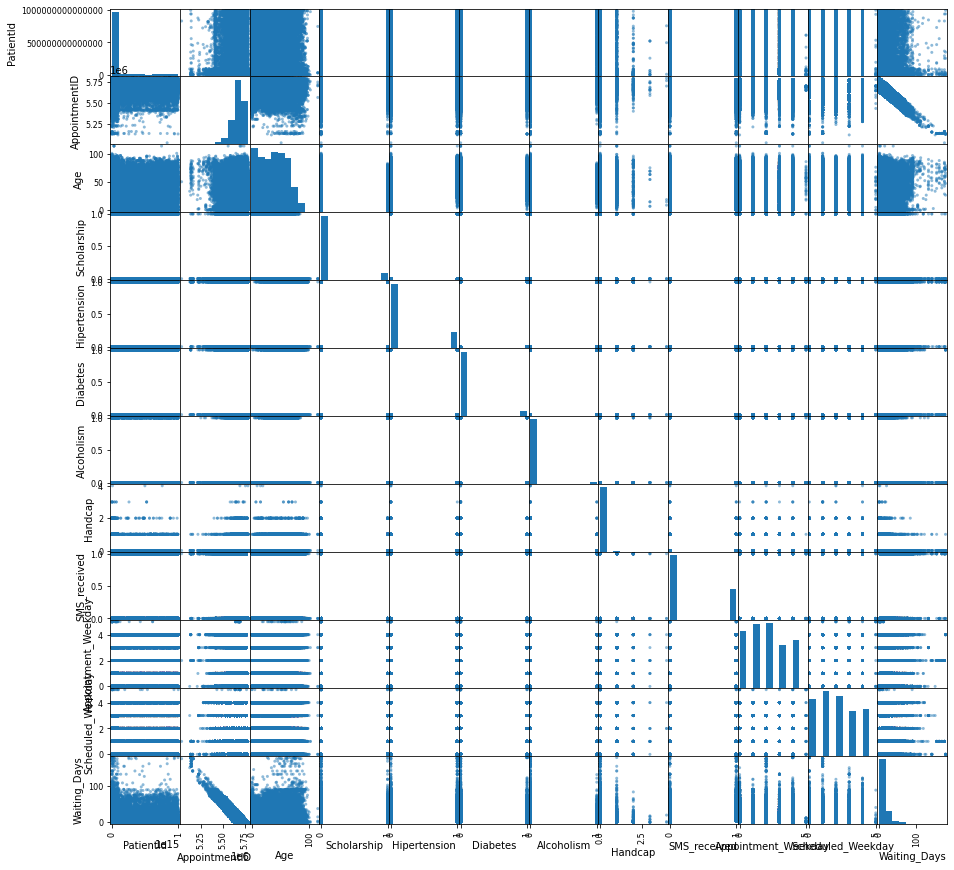

In [73]:
# Scatter Matrix
pd.plotting.scatter_matrix(df, figsize = (15,15));